# Clustering on generated data

In [140]:
import os
import sys

sys.path.append("../")

In [143]:
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from src.ml.sinkhorn import SinkhornValue, sinkhorn

In [12]:
sns.set(style="whitegrid")

## Dataset generation

In [129]:
n_features = 512
n_clusters = 10
batch_size = 256

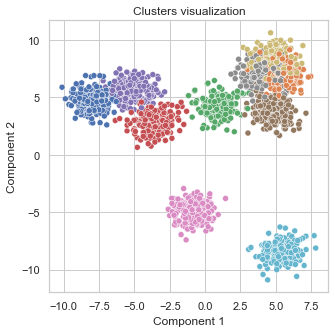

In [101]:
class BlobsDataset(Dataset):
    """
    https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
    """
    def __init__(self):
        X, y_true = make_blobs(
            n_samples=2000,
            n_features=n_features,
            centers=n_clusters,
            cluster_std=.8,
            random_state=0
        )
        
        self.X = torch.FloatTensor(X)
        self.y_true = torch.LongTensor(y_true)
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_true[idx]
    
    def plot(self):
        fig, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(5, 5)
        )

        sns.scatterplot(  # plot first 2 components
            x=self.X[:, 0],
            y=self.X[:, 1],
            hue=map(str, self.y_true),
            ax=ax,
            legend=False
        )

        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_title("Clusters visualization")

        return fig
    
blobs_dataset = BlobsDataset()
blobs_dataset.plot();

In [130]:
blobs_dataloader = DataLoader(
    blobs_dataset,
    shuffle=True,
    batch_size=batch_size
)

## Model definition

In [144]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )
    
    def forward(self, inputs):
        mlp_out = self.mlp(inputs)
        softmax_out = nn.LogSoftmax(dim=1)(mlp_out)
        
        return softmax_out

In [158]:
model = Model(
    input_dim=n_features,
    output_dim=n_clusters
)

optimizer = torch.optim.SGD(lr=0.001, params=model.parameters())

for epoch in range(10):
    epoch_loss = 0

    for batch_ix, (inputs, y_true) in enumerate(blobs_dataloader):
        a = torch.ones(inputs.shape[0]) / inputs.shape[0]  # batch size
        b = torch.ones(n_clusters) / n_clusters            # number of clusters
        
        model.train()

        P = model(inputs)
        M = P - np.log(inputs.shape[0])

        # set gradients to zero
        optimizer.zero_grad()

        # init Sinkhorn loss
        SV = SinkhornValue(
           a,
           b,
           epsilon=0.1,
           solver=sinkhorn,
           n_iter=100
        )

        # compute Sinkhorn loss
        loss = -SV(M)

        # compute gradients
        loss.backward()

        # backpropagation
        optimizer.step()

        epoch_loss += loss.item()
        
    print(epoch_loss / (batch_ix+1))

6.73539924621582
6.581467092037201
6.403274416923523
6.221059322357178
6.035268068313599
5.893588423728943
5.746087491512299
5.66621720790863
5.572878658771515
nan
